<a href="https://colab.research.google.com/github/scudilio/FIAP/blob/main/RN_Aula12_CNNTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 12 - CNNs e Transfer Learning

In [ ]:
# Imports
import tensorflow as tf
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Carregar o dataset
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True
)

In [ ]:
train_labels.shape

TensorShape([2569])

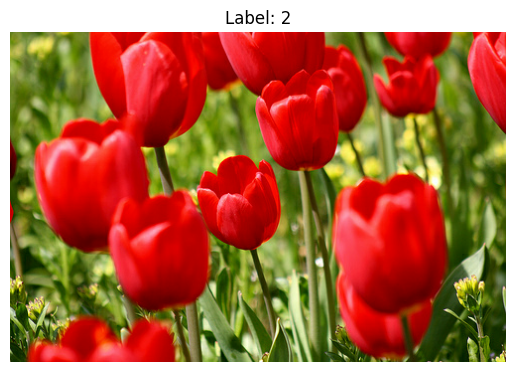

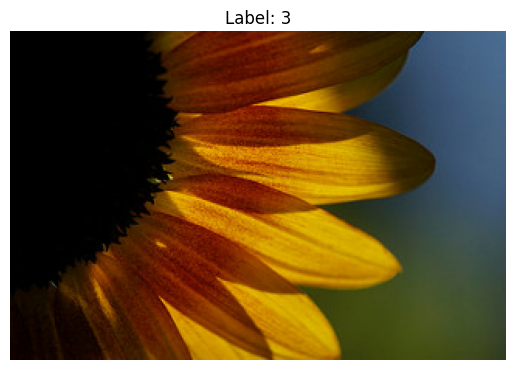

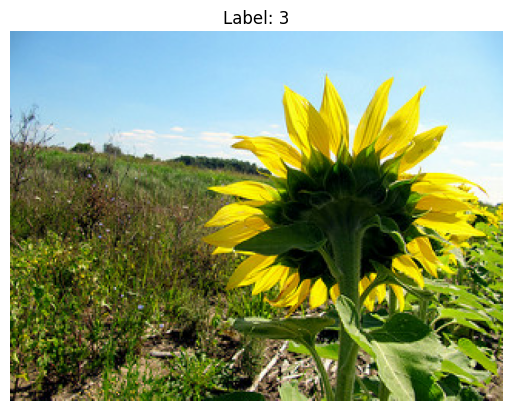

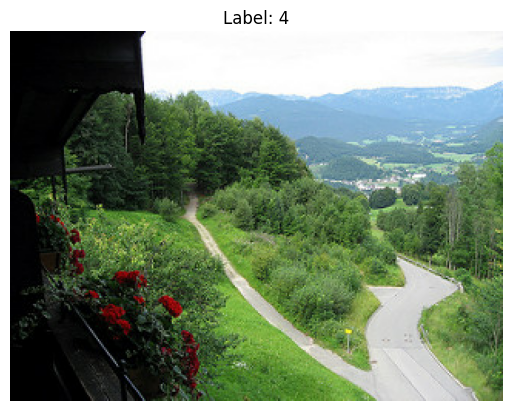

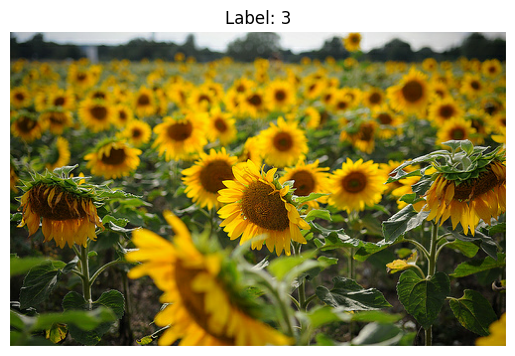

In [ ]:

# Carregar o dataset de forma não acumulada na memória
train_data, test_data = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    as_supervised=True
)

# Converter um pequeno número de imagens (por exemplo, 5) para arrays
def visualize_some_images(dataset, num_images = 10):
    dataset = dataset.take(num_images)  # Pega apenas algumas imagens
    for image, label in dataset:
        plt.figure()
        plt.imshow(image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()

# Visualizar algumas imagens do dataset de treino
visualize_some_images(train_data, num_images=5)

In [ ]:
train_ds.shape

TensorShape([2569, 442, 1024, 3])

In [ ]:
test_ds.shape

TensorShape([1101, 442, 1024, 3])

In [ ]:
train_labels

<tf.Tensor: shape=(2569,), dtype=int64, numpy=array([2, 3, 3, ..., 0, 2, 0])>

## Processar os dados

In [ ]:
size = (150, 150)

train_ds = tf.image.resize(train_ds, size)
test_ds = tf.image.resize(test_ds, size)

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
to_categorical(train_labels, num_classes=5)

<tf.Tensor: shape=(2569, 5, 5), dtype=float32, numpy=
array([[[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       ...,

       [[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]], dtype=float32)>

In [ ]:
train_labels

<tf.Tensor: shape=(2569, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

## Modelo "profundo" simples

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Rescaling

# Definir a arquitetura da CNN -> camada de extração de features
hand_model = Sequential()
hand_model.add( Rescaling(1./255, input_shape=(150, 150, 3)) )

hand_model.add( layers.Conv2D(16, kernel_size = 10, activation="relu") )
hand_model.add( layers.MaxPooling2D(3) )

hand_model.add( layers.Conv2D(32, kernel_size = 8, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) )

hand_model.add( layers.Conv2D(32, kernel_size=6, activation="relu") )
hand_model.add( layers.MaxPooling2D(2) )

# Definir a arquitetura da CNN -> camada de decisão (classificação)
hand_model.add( layers.Flatten() )                       # entrada
hand_model.add( layers.Dense(50, activation = "relu") )    # 1ª camada oculta
hand_model.add( layers.Dense(20, activation = "relu") )    # 2ª camada oculta
hand_model.add( layers.Dense(5, activation = "softmax") )  # camada de decisão

# Compilar o modelo
hand_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Definir a estratégia de Early Stopping
es = EarlyStopping(
    monitor="val_accuracy",
    patience = 5,
    restore_best_weights = True
)

# Treinar o modelo
with tf.device("/GPU:0"):
    hand_model.fit(
        train_ds, train_labels,
        epochs=50,
        validation_split = 0.2,
        batch_size=32,
        callbacks=[es]
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.2116 - loss: 1.6030 - val_accuracy: 0.2607 - val_loss: 1.5862
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.2669 - loss: 1.5795 - val_accuracy: 0.3619 - val_loss: 1.4907
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3366 - loss: 1.4832 - val_accuracy: 0.4300 - val_loss: 1.3708
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3963 - loss: 1.3816 - val_accuracy: 0.4358 - val_loss: 1.3041
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4697 - loss: 1.2152 - val_accuracy: 0.4455 - val_loss: 1.2210
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4717 - loss: 1.2177 - val_accuracy: 0.5019 - val_loss: 1.2120
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5448 - loss: 1.1049 - val_accuracy: 0.5331 - val_loss: 1.1726
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5520 - loss: 1.0716 - val_accuracy: 0.4903 -

In [ ]:
# Avaliação do modelo
loss, acc = hand_model.evaluate(test_ds, test_labels)

print(f"A loss do modelo é {loss:.2f} e a ACC é {acc:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7088 - loss: 0.7373
A loss do modelo é 0.74 e a ACC é 0.71


In [ ]:
# Função para obter a matriz de confusão
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
  labels = list( map( np.argmax, y_test ) )
  labels_pred = list( map( np.argmax, y_pred ) )

  cf_matrix = confusion_matrix(labels, labels_pred)
  sns.heatmap(cf_matrix, annot=True)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


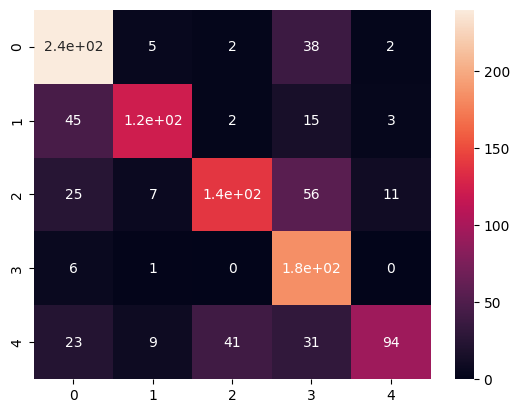

In [ ]:
# Matriz de confusão
preds = hand_model.predict(test_ds)
plot_confusion_matrix(test_labels, preds)

## **Trabalhando com Transfer Learning**

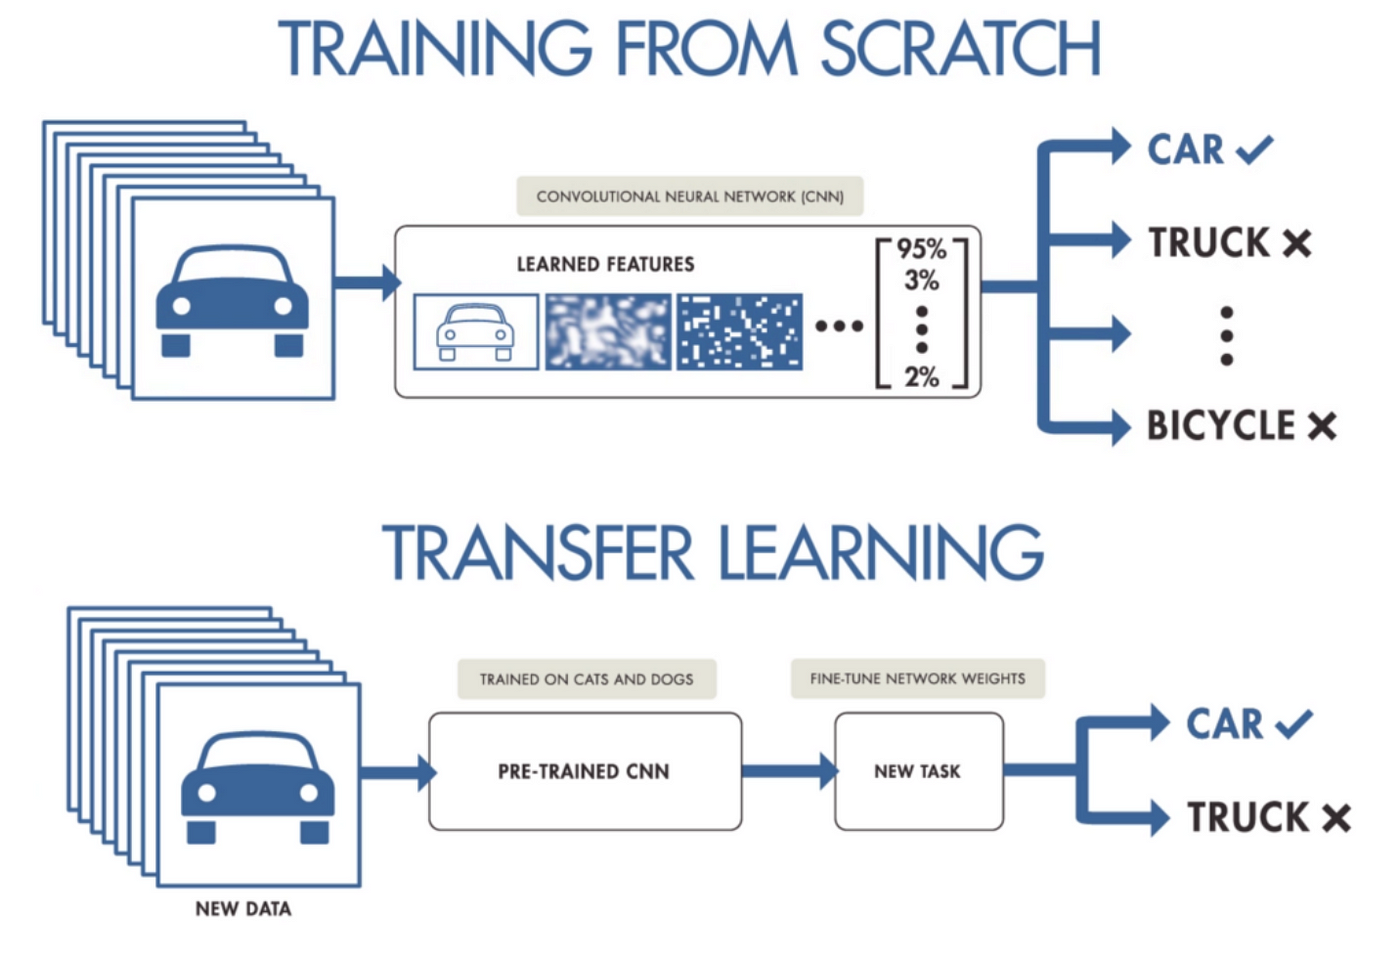

Transfer Learning (ou aprendizado por transferência) é uma técnica muito poderosa no aprendizado de máquina, especialmente em redes neurais profundas, onde um modelo treinado para uma tarefa pode ser reutilizado em outra tarefa relacionada. Isso é particularmente útil quando não há muitos dados disponíveis para treinar um modelo do zero.

Como funciona o Transfer Learning:
1. Modelo pré-treinado: No Transfer Learning, você utiliza um modelo que já foi treinado em um grande conjunto de dados, como ImageNet (um dataset enorme contendo milhões de imagens rotuladas). Esse modelo pré-treinado já aprendeu a extrair recursos úteis (features) das imagens, como bordas, formas e texturas.

2. Congelamento de camadas: Como o modelo já aprendeu a extrair recursos básicos das imagens, muitas vezes você pode "congelar" as primeiras camadas do modelo, ou seja, impedir que seus pesos sejam atualizados durante o treinamento. Essas camadas já capturam características visuais básicas que são úteis para muitas tarefas.

3. Redefinição das últimas camadas: As últimas camadas do modelo são normalmente as responsáveis por "tomar decisões" com base nos recursos extraídos, ou seja, realizar a tarefa de classificação final. No Transfer Learning, você pode substituir essas últimas camadas por camadas novas que correspondam à nova tarefa (como classificar diferentes tipos de objetos). Essas camadas novas serão treinadas com os seus dados específicos.

4. Ajuste fino (Fine-tuning): Em algumas situações, você pode permitir que as camadas mais profundas (ou todas as camadas) do modelo pré-treinado sejam ajustadas (os pesos podem ser atualizados), uma vez que a tarefa que você está treinando pode ser um pouco diferente da tarefa original. Isso é chamado de ajuste fino (fine-tuning).

Por que usar Transfer Learning?
Economia de tempo: Treinar redes neurais profundas do zero é muito demorado e exige muitos dados. Com Transfer Learning, você começa com um modelo já treinado e precisa treinar apenas uma parte (geralmente as camadas finais), economizando tempo e recursos.

Menos dados necessários: Mesmo que você tenha uma quantidade limitada de dados, usar um modelo pré-treinado pode ajudar, porque o modelo já aprendeu uma boa representação dos dados em tarefas similares.
Exemplos de Transfer Learning
Um dos casos mais comuns é a utilização de modelos pré-treinados em redes neurais convolucionais (CNNs) para tarefas de classificação de imagens:

Usar um modelo pré-treinado, como ResNet, Inception ou VGG: Esses modelos são treinados no dataset ImageNet (com 1000 classes de objetos), e você pode reutilizá-los para classificar diferentes tipos de imagens.



## MODELO VGG16
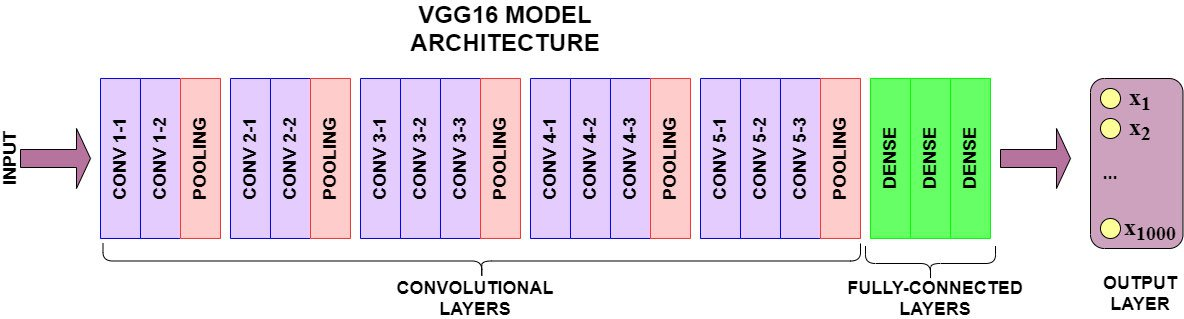


O VGG16 é uma arquitetura de rede neural convolucional (CNN) amplamente utilizada em tarefas de visão computacional, particularmente em problemas de classificação de imagens. Ele foi proposto pela equipe de pesquisa do Visual Geometry Group (VGG) da Universidade de Oxford e apresentado no trabalho "Very Deep Convolutional Networks for Large-Scale Image Recognition" em 2014. O VGG16 foi um dos modelos de destaque na competição ImageNet Large Scale Visual Recognition Challenge (ILSVRC) em 2014, tendo alcançado excelentes resultados.

Características principais do VGG16:
1. Profundidade: O "16" no nome VGG16 refere-se ao número de camadas treináveis na rede, que inclui 13 camadas convolucionais e 3 camadas densas (fully connected). Essas camadas são empilhadas de forma sequencial, o que dá à rede uma estrutura relativamente simples, mas profunda.

2. Camadas convolucionais pequenas: O VGG16 usa filtros de convolução pequenos de tamanho 3x3 em todas as camadas convolucionais, o que era uma novidade na época em comparação com outros modelos. Isso permite capturar características visuais finas sem aumentar significativamente o número de parâmetros.

3. Pooling com MaxPooling: Após blocos de camadas convolucionais, há camadas de MaxPooling de tamanho 2x2, que reduzem a dimensionalidade espacial das imagens (largura e altura), mas mantêm as características importantes aprendidas nas camadas convolucionais.

4. Camadas Fully Connected: No final da rede, após o processamento nas camadas convolucionais, há três camadas densas (fully connected), sendo a última uma camada de classificação com ativação softmax, que gera a probabilidade de cada classe no conjunto de dados.

5. Estrutura Simples e Uniforme: Uma característica interessante do VGG16 é sua simplicidade estrutural, pois a rede é composta por blocos convolucionais seguidos por pooling e, ao final, as camadas densas. Isso a torna fácil de entender e implementar.

**Arquitetura detalhada**:

A arquitetura do VGG16 pode ser descrita da seguinte forma:

*  Entrada: Imagens de tamanho fixo 224x224 pixels com 3 canais (RGB).

* Bloco 1:
Conv2D: 64 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 64 filtros de tamanho 3x3, seguido por ReLU.
MaxPooling: 2x2.

* Bloco 2:
Conv2D: 128 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 128 filtros de tamanho 3x3, seguido por ReLU.
MaxPooling: 2x2.

* Bloco 3:
Conv2D: 256 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 256 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 256 filtros de tamanho 3x3, seguido por ReLU.
MaxPooling: 2x2.

* Bloco 4:
Conv2D: 512 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 512 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 512 filtros de tamanho 3x3, seguido por ReLU.
MaxPooling: 2x2.
* Bloco 5:
Conv2D: 512 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 512 filtros de tamanho 3x3, seguido por ReLU.
Conv2D: 512 filtros de tamanho 3x3, seguido por ReLU.
MaxPooling: 2x2.

* Camadas Fully Connected (Densas):
Dense: 4096 unidades, seguido por ReLU.
Dense: 4096 unidades, seguido por ReLU.
Dense: 1000 unidades (softmax para 1000 classes do ImageNet).

In [ ]:
# Imports
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocessa os dados de treinamento e teste
train_dsTL = preprocess_input(train_ds)
test_dsTL = preprocess_input(test_ds)

In [ ]:
train_dsTL[0].shape

TensorShape([150, 150, 3])

VGG16:

VGG16 é a função da API Keras que carrega a arquitetura do modelo VGG16.
Esse modelo já foi treinado no dataset ImageNet, que contém milhões de imagens rotuladas em 1000 classes.
weights="imagenet":

Esta linha especifica que os pesos pré-treinados do modelo VGG16 serão carregados, e que esses pesos foram treinados no conjunto de dados ImageNet.
Ao usar pesos pré-treinados, o modelo já vem com conhecimentos adquiridos sobre padrões visuais gerais, como bordas, texturas e formas, tornando-o útil para Transfer Learning.
include_top=False:

O parâmetro include_top especifica se as camadas de decisão finais (ou "topo") do modelo devem ser incluídas.
include_top=False: Indica que a última parte da rede, que contém as camadas fully connected (densas) e a camada softmax usada para classificação das 1000 classes do ImageNet, será removida.

Por exemplo, se as imagens no dataset train_dsTL forem de tamanho 224x224 com 3 canais (RGB), input_shape seria (224, 224, 3).
Isso é necessário porque, ao remover a camada de topo (include_top=False), você precisa informar ao modelo qual é o formato das entradas (imagens) que serão passadas.

In [ ]:


# Importar o modelo de base, que será a VGG16 ***sem*** a camada de decisão
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape = train_dsTL[0].shape)

# Usar os mesmos pesos da rede treinada (sem fazer fine tuning)
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Observa a estrutura do modelo importado
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Adicionar a camada de decisão (classificação)

In [ ]:
from tensorflow.keras import layers, models

# Define as camadas
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation="relu")
dense_layer_2 = layers.Dense(20, activation="relu")
prediction_layer = layers.Dense(5, activation="softmax")

In [ ]:
# Estabelece o modelo completo
model = models.Sequential( [
    base_model,        # A base CNN vem da VGG16
    flatten_layer,     # Achata as features que saem da VGG16 (base_model)
    dense_layer_1,     # 1ª camada oculta fully connected
    dense_layer_2,     # 2ª camada oculta fully connected
    prediction_layer   # Camada de saída, com 5 neurônios para classificação
] )

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compilar o modelo
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Definir a estratégia de Early Stopping
es = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

# Treina o modelo
with tf.device("/device:GPU:0"):
  model.fit(
      train_dsTL, train_labels,  # alterei o nome do conjunto de treino, usando o train_dsTL
      epochs=50,
      validation_split=0.2,
      batch_size=32,
      callbacks=[es]
  )

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.3890 - loss: 3.6981 - val_accuracy: 0.5525 - val_loss: 1.2442
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6503 - loss: 0.9305 - val_accuracy: 0.6031 - val_loss: 1.0116
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.7432 - loss: 0.6420 - val_accuracy: 0.6518 - val_loss: 1.0807
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.7938 - loss: 0.5341 - val_accuracy: 0.6712 - val_loss: 1.0550
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.8331 - loss: 0.4739 - val_accuracy: 0.6751 - val_loss: 1.0554
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.8866 - loss: 0.2903 - val_accuracy: 0.6518 - val_loss: 1.0193
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.8917 - loss: 0.2810 - val_accuracy: 0.6498 - val_loss: 1.2340
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9169 - loss: 0.2413 - val_accurac

In [ ]:
# Avaliação do modelo
loss, acc = model.evaluate(test_dsTL, test_labels)

print(f"A loss do modelo é {loss:.2f} e a ACC é {acc:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.9988 - loss: 0.0108
A loss do modelo é 0.01 e a ACC é 1.00


In [ ]:
test_dsTL.shape

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


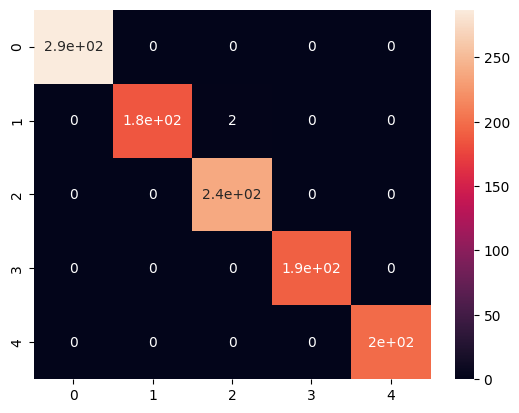

In [ ]:
preds = model.predict(test_dsTL)
plot_confusion_matrix(test_labels, preds)